In [0]:
#import thư viện cần thiết
## thư viện machine learning và hỗ trợ
import tensorflow as tf
from tensorflow import keras
import numpy as np
import cv2 

## thư viện để vẽ đồ thị
import matplotlib.pyplot as plt

### 1. Tải Data và Resize


In [0]:
# Tải dataset MNIST từ tensorflow
## MNIST là bài toán dự đoán một ảnh thể hiện ký tự số nào

## tải MNIST dataset từ keras
(X_train, y_train), (X_test, y_test) = keras.datasets.mnist.load_data()
##resacle ảnh thành ảnh thực trong đoạn [0,1]
X_train, X_test = X_train/255.0, X_test/255.0

##in dataset
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)


Kích thước tập sau khi resize:  (60000, 32, 32) (10000, 32, 32)


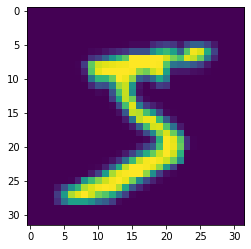

Kích thước tập sau khi reshape:  (60000, 32, 32, 1) (10000, 32, 32, 1)


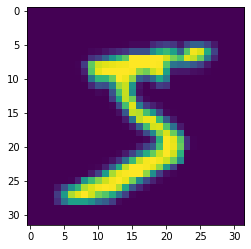

In [0]:
## Resize toàn bộ ảnh train tập train và test
X_train = np.array([cv2.resize(img, dsize=(32,32)) for img in X_train])
X_test = np.array([cv2.resize(img, dsize=(32,32)) for img in X_test])
print("Kích thước tập sau khi resize: ", X_train.shape, X_test.shape)

## In xem ảnh còn ổn không sau khi resize
plt.imshow(X_train[0])
plt.show()

## Reshape ảnh để phù hợp với input của model (thêm một trục)
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)
print("Kích thước tập sau khi reshape: ", X_train.shape, X_test.shape)

plt.imshow(X_train[0,:,:,0])
plt.show()

#Tách một phần tập train thành tập valid
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1)

### 2. VGG19


In [0]:
vgg19 = keras.applications.vgg19.VGG19(include_top=True, 
                                       weights=None, 
                                       input_tensor=None, 
                                       input_shape=(32,32,1), 
                                       pooling='max',
                                       classes=10)
vgg19.summary()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Model: "vgg19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        640       
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
______________________________________________

In [0]:
## import l2 regularizer
## l2 sẽ được khai báo truyền vào khi khởi tạo lớp
from keras.regularizers import l2
l2_regularizer_rate = 0.0005

## Tạo lớp input kích thước (None, 32, 32, 1)
inputs = keras.layers.Input(shape=(32,32,1))

### Block 1
#### Gồm 2 lớp convolution và 1 lớp maxpoool
#### Lớp convolution số filter 64, kernel size 3x3, hàm kích hoạt ReLU
conv1_1 = keras.layers.Convolution2D(filters=64,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(inputs)
conv1_2 = keras.layers.Convolution2D(filters=64,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(conv1_1)
maxpool1 = keras.layers.MaxPool2D(pool_size=[2,2],
                                  strides=[2,2])(conv1_2)

### Block 2
#### Gồm 2 lớp convolution và 1 lớp maxpoool
#### Lớp convolution số filter 128, kernel size 3x3, hàm kích hoạt ReLU
conv2_1 = keras.layers.Convolution2D(filters=128,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(maxpool1)
conv2_2 = keras.layers.Convolution2D(filters=128,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(conv2_1)
maxpool2 = keras.layers.MaxPool2D(pool_size=[2,2],
                                  strides=[2,2])(conv2_2)

### Block 3
#### Gồm 3 lớp convolution và 1 lớp maxpoool
#### Lớp convolution số filter 256, kernel size 3x3, hàm kích hoạt ReLU
conv3_1 = keras.layers.Convolution2D(filters=256,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(maxpool2)
conv3_2 = keras.layers.Convolution2D(filters=256,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(conv3_1)
conv3_3 = keras.layers.Convolution2D(filters=256,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(conv3_2)
conv3_4 = keras.layers.Convolution2D(filters=256,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(conv3_3)
maxpool3 = keras.layers.MaxPool2D(pool_size=[2,2],
                                  strides=[2,2])(conv3_4)

### Block 4
#### Gồm 3 lớp convolution và 1 lớp maxpoool
#### Lớp convolution số filter 512, kernel size 3x3, hàm kích hoạt ReLU
conv4_1 = keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(maxpool3)
conv4_2 = keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(conv4_1)
conv4_3 = keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(conv4_2)
conv4_4 = keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(conv4_3)
maxpool4 = keras.layers.MaxPool2D(pool_size=[2,2],
                                  strides=[2,2])(conv4_4)

### Block 5
#### Gồm 3 lớp convolution và 1 lớp maxpoool
#### Lớp convolution số filter 512, kernel size 3x3, hàm kích hoạt ReLU
conv5_1 = keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(maxpool4)
conv5_2 = keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(conv5_1)
conv5_3 = keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(conv5_2)
conv5_4 = keras.layers.Convolution2D(filters=512,
                                     kernel_size=[3,3],
                                     strides=[1,1],
                                     padding='same',
                                     activation=tf.nn.relu)(conv5_3)
maxpool5 = keras.layers.MaxPool2D(pool_size=[2,2],
                                  strides=[2,2])(conv5_4)

### Block cuối
#### Gồm 2 lớp fully-connected và 1 lớp output (cũng fully-connected)
#### Số neurons trong 3 lớp lần lượt là 4096, 4096, 10
flatten6 = keras.layers.Flatten()(maxpool5)
dense6_1 = keras.layers.Dense(units=4096, 
                              activation='relu',
                              kernel_regularizer=l2(l2_regularizer_rate))(flatten6)
dropout6_1 = keras.layers.Dropout(rate=0.5)(dense6_1)  ## Lớp Dropout (chỉ chạy khi train), rate: xác suất bị drop

dense6_2 = keras.layers.Dense(units=4096, 
                              activation='relu',
                              kernel_regularizer=l2(l2_regularizer_rate))(dropout6_1)
dropout6_2 = keras.layers.Dropout(rate=0.5)(dense6_2)  ## Lớp Dropout (chỉ chạy khi train), rate: xác suất bị drop

softmax = keras.layers.Dense(units=10, 
                             activation='softmax')(dropout6_2)


## Compile model
model = keras.models.Model(inputs=inputs, outputs=softmax)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001),    ##tự khai báo Optimizer với learning rate 10^-4
             loss=tf.keras.losses.sparse_categorical_crossentropy,
             metrics=["accuracy"])
    

## In toàn bộ cấu trúc của model
print("Cấu trúc của model: ")
model.summary()

Cấu trúc của model: 
Model: "model_7"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         [(None, 32, 32, 1)]       0         
_________________________________________________________________
conv2d_112 (Conv2D)          (None, 32, 32, 64)        640       
_________________________________________________________________
conv2d_113 (Conv2D)          (None, 32, 32, 64)        36928     
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_114 (Conv2D)          (None, 16, 16, 128)       73856     
_________________________________________________________________
conv2d_115 (Conv2D)          (None, 16, 16, 128)       147584    
_________________________________________________________________
max_pooling2d_36 (MaxPooling (None, 8,

In [0]:
### Tạo một callback ModelCheckpoint: callback này sẽ lưu model mỗi khi tìm được một model tốt hơn
#### filepath: đường dẫn file muốn lưu
#### monitor: đại lượng quyết định xem model có "tốt hơn" hay không
#### mode='auto'/'max'/'min': đại lượng monitor lớn hay nhỏ là tốt hơn
#### verbose: có thông báo mỗi lần lưu ko
#### save_best_only: chỉ lưu model tốt nhất
mc = keras.callbacks.ModelCheckpoint(filepath="vgg19_mnist.h5", 
                                     monitor='val_loss',
                                     mode='min', 
                                     verbose=0, 
                                     save_best_only=True)

## Train  ## Khuyến cáo chạy COLAB (hoặc tương tự)
history = model.fit(X_train, y_train,
                    batch_size=256,
                    epochs=20,
                    validation_data=(X_valid, y_valid),
                    callbacks=[mc])                     ##sử dụng callback ModelCheckpoint trong quá trình train


## Đánh giá model trên tập test
valid_loss, valid_acc = model.evaluate(X_valid, y_valid)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Valid: loss {} acc {} -- Test: loss {} valid {}".format(valid_loss, valid_acc, test_loss, test_acc))

## Load lại model tốt nhất đã lưu
print("\nbest model: ")
model.load_weights("vgg19_mnist.h5")
valid_loss, valid_acc = model.evaluate(X_valid, y_valid)
test_loss, test_acc = model.evaluate(X_test, y_test)
print("Valid: loss {}, acc {} -- Test: loss {}, valid {}".format(valid_loss, valid_acc, test_loss, test_acc))

Train on 54000 samples, validate on 6000 samples
Epoch 1/20
54000/54000 [==============================] - 64s 1ms/sample - loss: 2.8352 - acc: 0.3484 - val_loss: 1.3341 - val_acc: 0.7077
Epoch 2/20
54000/54000 [==============================] - 59s 1ms/sample - loss: 0.7691 - acc: 0.9039 - val_loss: 0.4929 - val_acc: 0.9665
Epoch 3/20
54000/54000 [==============================] - 59s 1ms/sample - loss: 0.4208 - acc: 0.9757 - val_loss: 0.3471 - val_acc: 0.9828
Epoch 4/20
54000/54000 [==============================] - 59s 1ms/sample - loss: 0.3164 - acc: 0.9829 - val_loss: 0.2694 - val_acc: 0.9868
Epoch 5/20
54000/54000 [==============================] - 59s 1ms/sample - loss: 0.2423 - acc: 0.9878 - val_loss: 0.2155 - val_acc: 0.9887
Epoch 6/20
54000/54000 [==============================] - 59s 1ms/sample - loss: 0.1920 - acc: 0.9899 - val_loss: 0.1943 - val_acc: 0.9860
Epoch 7/20
54000/54000 [==============================] - 59s 1ms/sample - loss: 0.1549 - acc: 0.9904 - val_loss: 0.1